CNN Notebook
Project : Street View House Numbers
By: Peiyao (Celine) Li , and Kevin Liu

In [17]:
# import all libraries
import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import io
from PIL import Image
from sklearn import datasets
from sklearn.metrics import accuracy_score
from scipy.io import loadmat
from sklearn import preprocessing
import h5py
import tensorflow as tf
from tensorflow.keras import layers, models

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

In [18]:
# loading the dataset from desktop
tr_set = "C:/Users/Celin/Desktop/CelineFirstJupyter/Street_num Final Project/Format 2/train_32x32.mat"
te_set = "C:/Users/Celin/Desktop/CelineFirstJupyter/Street_num Final Project/Format 2/test_32x32.mat"

In [19]:
# format 2 dataset load-in
data = loadmat(tr_set)
te_data = loadmat(te_set)

X_tr, y_tr = data['X'], data['y']
X_te, y_te = te_data['X'], te_data['y']

In [20]:
# explore training data details
print ("Training Set Shape Params: <width, height, channels [rgb], # of images>")
print("X Shape: ", X_tr.shape, " y Shape: ", y_tr.shape)

Training Set Shape Params: <width, height, channels [rgb], # of images>
X Shape:  (32, 32, 3, 73257)  y Shape:  (73257, 1)


In [21]:
#explore numbers of pixels in total in each set
X_tr.size, X_te.size

(225045504, 79970304)

In [22]:
# transpose data to (# of images, width, height, rgb)
X_tr, y_tr = X_tr.transpose((3,0,1,2)), y_tr[:,0]
X_te, y_te = X_te.transpose((3,0,1,2)), y_te[:,0]
print("X Shape: ", X_tr.shape, " y Shape: ", y_tr.shape)

X Shape:  (73257, 32, 32, 3)  y Shape:  (73257,)


In [23]:
#count the number of original data per label n test and training data
import collections
print(collections.Counter(y_te))
print(collections.Counter(y_tr))

Counter({1: 5099, 2: 4149, 3: 2882, 4: 2523, 5: 2384, 7: 2019, 6: 1977, 10: 1744, 8: 1660, 9: 1595})
Counter({1: 13861, 2: 10585, 3: 8497, 4: 7458, 5: 6882, 6: 5727, 7: 5595, 8: 5045, 10: 4948, 9: 4659})


In [24]:
#take 2000 training data and 400 test data
X_tr_new=[]
y_tr_new=[]
X_te_new=[]
y_te_new=[]
# y_train_new=list(y_train)
# X_train_new=list(X_train)

for i in range(1,11):
    for a,b in zip(X_tr,y_tr):
        if b == i and y_tr_new.count(i)<200:
            X_tr_new.append(a)
            y_tr_new.append(b)
        else:
            continue
            
for i in range(1,11):
    for a,b in zip(X_te,y_te):
        if b == i and y_te_new.count(i)<80:
            X_te_new.append(a)
            y_te_new.append(b)
        else:
            continue

In [25]:
#double check the count of each label in the new data
for i in range(1,11):
    print(y_tr_new.count(i))
    print(y_te_new.count(i))

200
80
200
80
200
80
200
80
200
80
200
80
200
80
200
80
200
80
200
80


In [26]:
X_tr=np.array(X_tr_new)
y_tr= np.array(y_tr_new)
X_te=np.array(X_te_new)
y_te= np.array(y_te_new)
print("X Shape: ", X_tr.shape, " y Shape: ", y_tr.shape)

X Shape:  (2000, 32, 32, 3)  y Shape:  (2000,)


In [27]:
# explore all the labels , note that 0 was originally labled as 10
np.set_printoptions(threshold=np.inf)
# print(y_tr)

In [28]:
# change all label "10" to 0 as shown in images
for i in range(len(y_tr)):
    if (y_tr[i]==10):
        y_tr[i]=0
for i in range(len(y_te)):
    if (y_te[i]==10):
        y_te[i]=0  
# print(y_tr)#check to see the new labels

In [29]:
# convert RGB to grayscale
def rgb2gray(img_data):
    return np.expand_dims(np.dot(img_data, [0.3, 0.6, 0.1]), axis=3)

X_tr_gr = rgb2gray(X_tr).astype(np.float32) # converts gray training set to float values
print("Training Set", X_tr_gr.shape)
X_tr = X_tr_gr # replace original training set

X_te_gr = rgb2gray(X_te).astype(np.float32) # converts gray testing set to float values
print("Testing Set", X_te_gr.shape)
X_te = X_te_gr # replace original testing set

Training Set (2000, 32, 32, 1)
Testing Set (800, 32, 32, 1)


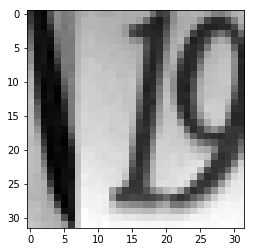

In [30]:
# show an example image using gray scale
digit_img = X_tr[0].reshape((32,32))
plt.imshow(digit_img, cmap='gray')
plt.show()

In [31]:
X_tr_resized = X_tr.reshape(73257, 32*32*1)
X_te_resized = X_te.reshape(26032, 32*32*1)

ValueError: cannot reshape array of size 2048000 into shape (73257,1024)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_tr = sc_X.fit_transform(X_tr_resized)
X_te = sc_X.transform(X_te_resized)

In [ ]:
# create train and test set
train_images = X_tr
test_images = X_te
train_labels = y_tr
test_labels = y_te

In [ ]:
# print max values to scale the values 
print(np.max(train_images))
print(np.max(test_images))

In [ ]:
# normalize the values between 0 to 1
# train_images, test_images = train_images / 255.0, test_images / 255.0

In [ ]:
#CNN model define the 3 layers 
# the first two convolutional layers are followed by a MaxPooling where the size of the output is reduced
# 3 by 3 is standard filter size in CNN, and 32/64/128 are the standard output channel depths, by convention the latter layers have more depth
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), input_shape=(1)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.MaxPooling2D((2, 2)))
model.summary()

In [ ]:
# define dense layer array
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.4))#it is found that dropout=0.4 peforms best
#model.add(layers.LeakyReLU(alpha=0.1)) , it is found the this dense layer performs better with relu rather than leaky relu
model.add(layers.Dense(10, activation='softmax'))
model.summary()

In [ ]:
# compile model and train the dataset
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels, epochs=10)


In [ ]:
# testing
test_loss, test_acc = model.evaluate(test_images, test_labels)


In [ ]:
# testing accuracy output
print(test_acc)


In [ ]:
#Check the softmax distribution for each category for the first 10 images and print their labels
output = model.predict(test_images[:10])
print(output)
print(np.argmax(output, axis=1))

In [ ]:
# view 10 test images to make sure they actually match their labels printed above, and they do! yay!
X_orig_tr = data['X']
X_orig_te = te_data['X']

for i in range(0,10):
    show_img = X_te[i].reshape((32,32))
    print(show_img.shape,y_te[i])
    plt.imshow(show_img)
    plt.show()
